ChEn-5310: Computational Continuum Transport Phenomena Spring 2021 UMass Lowell; Prof. V. F. de Almeida **05Mar21**

# 07. Poisson 1D with Dirichlet-Neumann Boundary Conditions
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
1. [Plotting Functions](#plotting)
<br><br> 
1. [Problem Statement](#problem)
 + [Strong Form](#strong)
 + [Natural (Normal Flux) Boundary Condition Case (Neumann)](#nbc)
 + [Variational Form](#variational)
 + [Poisson-Dirichlet Energy](#energy)
 <br><br>
1. [Problem Solution](#solution)
  + [Use Neumann Boundary Condition from MOOSE](#moosefluxbc)
  + [Code a Normal Flux Boundary Condition Kernel](#fluxbc)
  + [Compile and Link Application](#compilelink1)
<br><br>   
1. ["Draining" Boundary Condition (input file)](#drain)
  + [Run App](#drainrun)
  + [Quadratic Lagrange FEM Results](#drainresults)
<br><br>   
1. ["Feeding" Boundary Condition (input file)](#feed)
  + [Run App](#feedrun)
  + [Quadratic Lagrange FEM Results](#feedresults)
<br><br>   
1. [Energy Postprocessing](#energypostpro)
 + [Code the Energy Postprocessor](#postpro)
<br><br>  
1. [Application Tree](#tree)

## [Objectives](#toc)<a id="obj"></a>

 + This is a continuation of the Poisson 1D problem with Dirichlet boundary conditions detailed in [Notebook 06](https://nbviewer.jupyter.org/github/dpploy/engy-5310/blob/main/notebooks/06-poisson-1d-dirichlet.ipynb); some information may not be duplicated here.
 + Introduce the Galerkin variational (weak) form of the Poisson 1D problem below ([OneNote notes here](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Eib-vZHIpRlPlOMtz0Gf_asBegEFKsl9dOK4nHyDbgSeUA?e=sLu1td)).
 + Introduce the use of combined Dirichlet and Neumann boundary conditions.
 + Use second order accurate finite element Lagrange basis functions to solve the problem numerically.
 + <span style="color:red">Some initial code is provided in the course repository but no full source code is given out. If you do not do a minimum of programing you will not learn basic aspects of this subject. Hands-on work during lectures will fill in this gap. If you do all the steps proposed in this notebook and attend the working lectures you will only have an initial knowledge of the subject.</span>

## [Plotting Functions](#toc)<a id="plotting"></a>

This is an auxiliary section for holding plotting functions used later.

In [1]:
'''Plot function for FEM Solution'''

def plot_solution(df, 
                  title='No Title', 
                  basis_functions_type='No basis functions type',
                  flux_basis_functions_type='No basis functions type'):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('dark_background')

    (fig, ax1) = plt.subplots(1, figsize=(14, 5))

    ax1.plot(df['x'], df['u'],'r*-',label=basis_functions_type)

    ax1.set_xlabel(r'$x$ [cm]', fontsize=18)
    ax1.set_ylabel(r'$u_h(x)$ [g/cc]', fontsize=18, color='red')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='center left', fontsize=12)
    #ax1.set_ylim(0,1)
    ax1.grid(True)

    if 'diffFluxU_x' in df.columns:
        # create a twin x axis to be shared
        ax2 = ax1.twinx()

        ax2.plot(df['x'], df['diffFluxU_x'],'*-', color='yellow', label=flux_basis_functions_type)

        ax2.set_ylabel(r"$q_h(x)$ [g/cm2-s]", fontsize=16, color='yellow')
        ax2.tick_params(axis='y', labelcolor='yellow', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
        #ax2.set_ylim(0,2)
        #ax2.grid(True)

    plt.title(title, fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

In [2]:
'''Plot Function for Error Compared to Exact Dimensionless Solution'''

def plot_solution_error(df, fem_type='No FEM type'):
    
    from engy_5310.toolkit import engy5310_p1_exact_solution

    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('dark_background')
    
    (u_hat, _, _) = engy5310_p1_exact_solution(x_a, x_b, u_a, u_b, diff_coeff, source_s)

    L = df['x'].max() - df['x'].min()
    x_mean = (df['x'].max() + df['x'].min())/2.0
    x_hat = (df['x'] - x_mean)/L
    a_hat = u_a/source_s*diff_coeff/L**2
    b_hat = u_b/source_s*diff_coeff/L**2

    uh_hat = df['u']/source_s*diff_coeff/L**2

    plt.figure(1, figsize=(14, 5))
    
    plt.plot(x_hat, uh_hat,'r-*',label=fem_type)
    
    plt.plot(x_hat, u_hat(x_hat, a_hat, b_hat), 'x', color='yellow', label='Exact Solution')

    plt.plot(x_hat, uh_hat-u_hat(x_hat, a_hat, b_hat), 'x', color='magenta', label=r'$\hat{u}_h-\hat{u}$')
    
    plt.title('Dimensionless FEM Solution and Error', fontsize=20)
    plt.ylabel(r'$\hat{u}_h, \hat{u}$', fontsize=18)
    plt.xlabel(r'$\hat{x}$', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc='best',fontsize=12)
    plt.grid(True)
    plt.show()

In [3]:
'''Plot Function for Error Compared to Exact Dimensionless Solution'''

def plot_flux_error(df, fem_type='No FEM type'):
    
    from engy_5310.toolkit import engy5310_p1_exact_solution
        
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('dark_background')
    
    (_, flux_hat, _) = engy5310_p1_exact_solution(x_a, x_b, u_a, u_b, diff_coeff, source_s)

    L = df['x'].max() - df['x'].min()
    x_mean = (df['x'].max() + df['x'].min())/2.0
    x_hat = (df['x'] - x_mean)/L
    
    a_hat = u_a/source_s*diff_coeff/L**2
    b_hat = u_b/source_s*diff_coeff/L**2

    flux_h_hat = df['diffFluxU_x']/source_s/L

    plt.figure(1, figsize=(14, 5))
    
    plt.plot(x_hat, flux_h_hat, 'r-*', label=fem_type)
    
    plt.plot(x_hat, flux_hat(x_hat, a_hat, b_hat), 'x', color='yellow', label='Exact Solution')

    plt.plot(x_hat, flux_h_hat-flux_hat(x_hat, a_hat, b_hat),'x',color='magenta',label=r'$\hat{q}_h-\hat{q}$')
    
    plt.title('Dimensionless FEM Solution and Error', fontsize=20)
    plt.ylabel(r'$\hat{q}_h, \hat{q}$', fontsize=18)
    plt.xlabel(r'$\hat{x}$', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc='best',fontsize=12)
    plt.grid(True)
    plt.show()

## [Problem Statement](#toc)<a id="problem"></a>

The following sections describe what is referred in the literature as the one-dimensional Poisson problem with Dirchlet-Neumann boundary conditions.

### [Strong Form of Problem Statement](#toc)<a id="strong"></a>

Solve the Poisson model problem. Find $u:[a,b]\subset\Reals\rightarrow\Reals$ for $D > 0$ such that:

\begin{align*}
 -\bigl(-D\, u'\bigr)'(x) + S &= 0 \quad \forall \quad x\in [a,b], \\
 u(a) &= A, \\
 q_n(b) &= q_{nb}.
\end{align*}
   
Solve this problem analytically for the constants: diffusion coefficient, $D$, source, $S$, entry concentration, $A$, and exit normal flux, $q_{nb}$. 

### [Natural (Normal Flux) Boundary Condition Case (Neumann)](#toc)<a id="nbc"></a>

The diffusion flux associated to $u$ is defined as

\begin{equation*}
 q(x) := -D\,u'(x).
\end{equation*}

The normal diffusion flux evaluated at boundary points is defined in 1D as:

\begin{align*}
 q_n(a) &:= - q(a), \quad \text{the normal flux at $a$ is equal to the negative of the flux at $a$},  \\
 q_n(b) &:= q(b) \quad \text{the normal flux at $b$ is equal to the flux at $b$}.
\end{align*}

Therefore a positive value of normal flux $q_n$ at any boundary point indicates that the quantity $u$ is removed at the boundary. Otherwise, when $q_n$ is negative, $u$ is greater at the boundary as compared to the interior. The *normal* qualification here refers to the direction of the outward pointing vector at the boundary. Since this is a 1D problem, at the exit $b$, the normal aligns with the coordinate $x$ direction. At $a$ the normal is pointing in the opposite direction of the coordinate system; therefore the minus sign in the above definition.

In the literature, the **Neumann boundary condition** is given on the *normal derivative* (or normal gradient) of the unknown variable. This is not the same as the normal diffusion flux but related.

Here we will employ a mix of Dirichlet boundary condition on the entry point and a normal flux boundary condition on the exit point. That is:

\begin{align*}
 u(a) &= A, \\
 -D\,u'(b) &= q_n(b) = q_{nb},
\end{align*}

where $q_b$ is the value to be specified. If this value is positive, $u$  will be depleted at the boundary.

### [Variational Form of Problem Statement](#toc)<a id="variational"></a>

The Galerkin weak formulation is as follows. Find $u \in H^1\!\bigl([a,b]\bigr)$ so that 

\begin{align*}
 \int\limits_a^b -D\, u'(x)\,v'(x)\,dx - q_n(b)\,v(b) + \int\limits_a^b S\,v(x)\,dx  &= 0 \quad \forall \quad v \in H^1_0\!\bigl([a,b]\bigr), 
\end{align*}

where $H^1\!\bigl([a,b]\bigr) := \bigl\{ u:[a,b]\subset\Reals\rightarrow \Reals \mid \int_a^b u'^2\,dx < \infty \bigr\}$ and 
$H^1_0\!\bigl([a,b]\bigr) := \bigl\{ v \mid v \in H^1\!\bigl([a,b]\bigr), v(a) = 0 \bigr\}$. This variational form is a modified Galerkin's weak form including the Neumann boundary condition.

### [Poisson-Dirichlet Energy](#toc)<a id="energy"></a>

The associated energy that the variational form minimizes is the **mixed Dirichlet/Neumann total energy**:

\begin{align*}
 \Phi[u] := \int\limits_a^b \,\frac{1}{2}\bigl(q(x)\bigr)^2 - D\,S\,u(x) \,dx + D\,q_n(b)\,u(b).
\end{align*}

## [Problem Solution](#toc)<a id="solution"></a>

The previously developed code for the Dirichlet boundary condition (Notebook 06) case remains unchanged and usable.
To setup the new term in the weak form, there exist two options (you should do both): 

 1. The first, is to use the internal `MOOSE` framework implementation of the `NeumannBC` type in the boundary condition block of the input file. Start by just modifying your `MOOSE` boundary condition block in the input file as described [below](#moosefluxbc).
 1. The second, involves the implementation of a new MOOSE kernel to be added to the weak form terms. This is the approach followed [here](#fluxbc) and there is a template in the course repository, `EquationFluxBC` which can be used as a starting point. In the Input file blocks shown below, the `type = NormalFluxBC` was created in the `Engy5310P1App` for this example. This approach implements an extended version of the normal diffusion flux [(see also Notebook 08)](https://nbviewer.jupyter.org/github/dpploy/engy-5310/blob/main/notebooks/08-poisson-1d-robin.ipynb).


### [Use Neumann Boundary Condition from MOOSE](#toc)<a id="moosefluxbc"></a>

```
[BCs]
  [entry]
    type = DirichletBC  # part of MOOSE
    variable = u
    boundary = left
    value = 3.00000e+00
  []
  [exit]
    type = NeumannBC  # part of MOOSE
    variable = u
    boundary = right
    value = 4.10000e-01   # part of MOOSE
  []
[]

```

### [Code a Normal Flux Boundary Condition Kernel](#toc)<a id="fluxbc"></a>

To make this useful for the Robin boundary condition case later (Notebook 08), implement a linear transfer function as follows:

\begin{equation*}
 q_n(x) =  q_\text{bias} + h\,\bigl(u(x) - u_\infty\bigr).
\end{equation*}

but set $h$ to zero at the moment.

1. `cd include`
1. `mkdir bcs`
1. `cd bcs`
1. Create a `NormalFluxBC.h` class interface as folows:
 + Use the `EquationFluxBC.h` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/EquationFluxBC.h) as follows:
 + `cp *path-to*/moose-app-templates/EquationFluxBC.h .`
 + `mv EquationFluxBC.h NormalFluxBC.h`
 + Edit the file `NormalFluxBC.h` with a text editor by replacing all instances of `EquationFluxBC` with `NormalFluxBC`.
 + Suggestion: you will need to declare member variables named `_bias`, `_transferCoeff`, `_reference`, as `Real` data type.
1. `cd ../..`
1. `cd src`
1. `mkdir kernels`
1. `cd kernels`
1. Create a `NormalFluxBC.C` class implementation as follows:
 + Use the `EquationFluxBC.C` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/EquationFluxBC.C) as follows.
 + `cp *path-to*/moose-app-templates/EquationFluxBC.C .`
 + `mv EquationFluxBC.C NormalFluxBC.C`
 + Edit the file `EquationFluxBC.C` with a text editor by replacing all instances of `EquationFluxBC` with `NormalFluxBC`.
 + You will need to program the *residual* and *Jacobian* methods. <span style="color:red">This portion of the implementation is covered in class.</span>

### [Compile and Link Application](#toc)<a id="compilelink1"></a>

1. Make sure you are in the problem project:
 +  `cd ../..`
 + `pwd`
1. You should see: `..../engy5310p1`
1. Compile and link the application
 + `make`
1. If all is sucessfull you should see among other things in the screen output:
 + Linking Library `.../engy5310p1/lib/libengy5310p1-opt.la...`
 + Linking Executable `.../engy5310p1/engy5310p1-opt...`

## ["Draining" Boundary Condition (input file)](#toc)<a id="drain"></a>

The *draining* boundary condition uses a positive normal diffusion flux at the exit point, therefore there exists diffusion *removal* of material at that point.

Using the previous `input.hit` input file (edit with a text editor), the `exit` block was modified as follows:

```
[BCs]
  [entry]
    type = DirichletBC  # part of MOOSE
    variable = u
    boundary = left
    value = 3.00000e+00
  []
  [exit]
    type = NormalFluxBC  # user built
    variable = u
    boundary = right
    bias = 4.10000e-01   # user built
  []
[]

```


Save the input file in the `.../engy5310p1/` directory.

### [Run Application](#toc)<a id="drainrun"></a>

1. In the `engy5310p1/` directory run the application with the Linux shell command:
 + `./engy5310p1-opt -i input.hit`

### [Quadratic Lagrange FEM](#toc)<a id="drainresults"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + qn_b = 0.41 g/cm^2-s  (the bias parameter)
> + D = 0.1 cm^2/s
> + S = 5e-2 g/cc-s

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 1

In [4]:
'''Domain'''

x_left = 0
x_right = 25

x_length = x_right - x_left

In [5]:
'''Parameters and data'''

diff_coeff = 0.1
source_s = 5e-2

u_left = 3
qn_right = 0.41 # draining on the exit boundary; normal diffusion flux is positive

In [19]:
'''FEM Solution'''

n_felem = 1

order = 'second'

n_plot_pts = 2*n_felem + 1
n_plot_pts = 10

try:    
    from engy_5310.toolkit import write_engy5310_p1_1d_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_p1_1d_input_file(x_left=x_left, x_right=x_right, u_left=u_left, qn_bias_right=qn_right, 
                             diff_coeff=diff_coeff, source_s=source_s, n_felem=n_felem, order=order, 
                             n_plot_pts=n_plot_pts, compute_diffusion_flux=True)

In [20]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 19Apr21 13:07:16

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 5.00000e-02
u_left = 3.00000e+00
qn_bias_right = -5.00000e-01

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 1
    elem_type = edge3
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
    initial_condition = ${replace u_left}
  []
[]

[AuxVariables]
  [diffFluxU]
    order = FIRST
    family = MONOMIAL_VEC
  []
  [diffFluxU_x]
    order = FIRST
    family = MONOMIAL
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = u     # add to produced quantity
    sourceS = ${replace source_s}


In [21]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit 52562be492 on 2021-04-09
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Mon Apr 19 13:07:34 2021
Executable Timestamp:    Sat Apr 17 21:27:24 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 3
    Local:                 3
  Elems:                   
    Total:                 1
    Local:                 1
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                3
  Num Local DOFs:          3
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                4
  Num Local DOFs:          4
  Variables:    

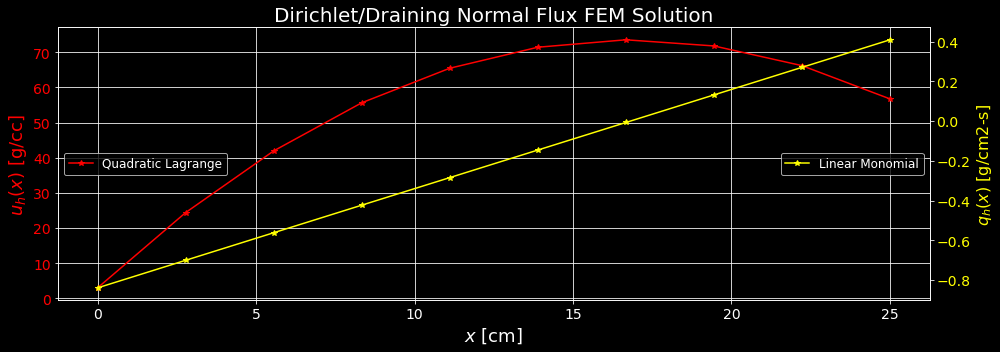

In [9]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')

plot_solution(df, title='Dirichlet/Draining Normal Flux FEM Solution', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

**Comments:**

1. Because the flux at the exit is specified as positive, there is outgoing diffusion at the exit point of the domain, hence despite the constant source, the exit concentration is reduced to a level lower than the internal concentration. If the specified flux is too high compared to the source (or the source small compared to the flux) it will drive the concentration values at the exit to unphysical negative values.
1. Note that 1 finite element was used.

## ["Feeding" Boundary Condition (input file)](#toc)<a id="feed"></a>

The *feeding* boundary condition uses a negative normal diffusion flux at the exit point, therefore there exists diffusion *feed* of material at that point.

In a similar way to the *draining* flux previously described the input file was modified as follows:

```
[exit]
  type = NormalFluxBC
  variable = u
  boundary = right
  bias = -0.5
[]
```


Save the input file in the `.../engy5310p1/` directory.

### [Run Application](#toc)<a id="feedrun"></a>

1. In the `engy5310p1/` directory run the application with the Linux shell command:
 + `./engy5310p1-opt -i input.i`

### [Quadratic Lagrange FEM](#toc)<a id="feedresults"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + qn_b = -0.5 g/cm^2-s (the bias parameter)
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 1

In [10]:
'''Parameters and data'''

qn_right = - 0.5 # feeding on the exit boundary; normal flux is negative

In [11]:
'''FEM Solution'''

n_felem = 1
order = 'second'
#n_plot_pts = 2*n_felem + 1
n_plot_pts = 10

try:    
    from engy_5310.toolkit import write_engy5310_p1_1d_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_p1_1d_input_file(x_left=x_left, x_right=x_right, u_left=u_left, qn_bias_right=qn_right, 
                             diff_coeff=diff_coeff, source_s=source_s, n_felem=n_felem, order=order, 
                             n_plot_pts=n_plot_pts, compute_diffusion_flux=True, use_moose_neumann_bc=False)

In [12]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 19Apr21 13:04:44

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 5.00000e-02
u_left = 3.00000e+00
qn_bias_right = -5.00000e-01

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 1
    elem_type = edge3
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
    initial_condition = ${replace u_left}
  []
[]

[AuxVariables]
  [diffFluxU]
    order = FIRST
    family = MONOMIAL_VEC
  []
  [diffFluxU_x]
    order = FIRST
    family = MONOMIAL
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = u     # add to produced quantity
    sourceS = ${replace source_s}


In [13]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit 52562be492 on 2021-04-09
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Mon Apr 19 13:04:45 2021
Executable Timestamp:    Sat Apr 17 21:27:24 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 3
    Local:                 3
  Elems:                   
    Total:                 1
    Local:                 1
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                3
  Num Local DOFs:          3
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                4
  Num Local DOFs:          4
  Variables:    

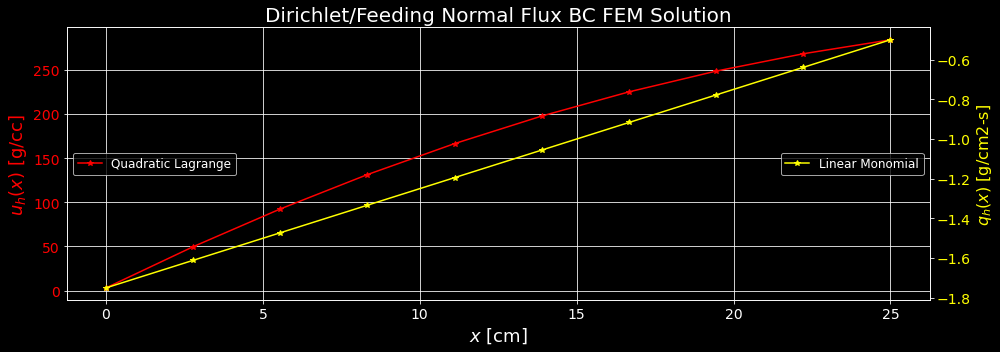

In [14]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')

plot_solution(df, title='Dirichlet/Feeding Normal Flux BC FEM Solution', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

**Comments:**

1. Because the normal flux at the exit is specified as negative, there is incoming diffusion into the domain, hence the concentration is higher at the exit than the entry point. The average concentration in the domain is greatly increased at steady state.
1. Note that 1 finite element was used.

## [Energy Postprocessing](#toc)<a id="energypostpro"></a>

To compute the [Poisson-Dirichlet energy](#energy) a *Postprocessor* needs to be built. The integral of the flux magnitude squared over the domain has been implemented in Notebook 06 for the Dirichlet energy. Here the normal flux term evaluated at the boundary needs to be implemented.

### [Code the Energy Postprocessor](#toc)<a id="postpro"></a>

coming soon...


In [15]:
'''FEM Solution'''

n_felem = 1

order = 'second'

#n_plot_pts = 2*n_felem + 1
n_plot_pts = 10

try:    
    from engy_5310.toolkit import write_engy5310_p1_1d_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_p1_1d_input_file(x_left=x_left, x_right=x_right, u_left=u_left, qn_bias_right=qn_right, 
                             diff_coeff=diff_coeff, source_s=source_s, n_felem=n_felem, order=order, 
                             n_plot_pts=n_plot_pts, 
                             compute_diffusion_flux=True, use_moose_neumann_bc=False, compute_energy=True)

In [16]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 19Apr21 13:04:45

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 5.00000e-02
u_left = 3.00000e+00
qn_bias_right = -5.00000e-01

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 1
    elem_type = edge3
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
    initial_condition = ${replace u_left}
  []
[]

[AuxVariables]
  [diffFluxU]
    order = FIRST
    family = MONOMIAL_VEC
  []
  [diffFluxU_x]
    order = FIRST
    family = MONOMIAL
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = u     # add to produced quantity
    sourceS = ${replace source_s}


In [17]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit 52562be492 on 2021-04-09
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Mon Apr 19 13:04:45 2021
Executable Timestamp:    Sat Apr 17 21:27:24 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 3
    Local:                 3
  Elems:                   
    Total:                 1
    Local:                 1
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                3
  Num Local DOFs:          3
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                4
  Num Local DOFs:          4
  Variables:    

## [Application Tree](#toc)<a id="tree"></a>

This tree printout helps the understanding of various pieces of the `MOOSE` application repository created after all the above steps including future implementations in the notebooks following the present one that cover various boundary conditions.

In [18]:
!tree engy5310p1

engy5310p1
├── LICENSE
├── Makefile
├── README.md
├── __pycache__
│   └── chigger.cpython-38.pyc
├── build
│   ├── header_symlinks
│   │   ├── BoundaryEnergy.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/postprocessors/BoundaryEnergy.h
│   │   ├── BulkEnergy.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/postprocessors/BulkEnergy.h
│   │   ├── ConvectionTerm.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/kernels/ConvectionTerm.h
│   │   ├── DiffusionFlux.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/auxkernels/DiffusionFlux.h
│   │   ├── DiffusionFluxComponent.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/auxkernels/DiffusionFluxComponent.h
│   │   ├── DiffusionTerm.h 